# 1. Introduction: Plotting a Time Series of HMDA Filers, 2004 - 2017  

In order to produce this table, we would need information from each transmittal sheet. This notebook demonstrates how to pull counts and activity year from each transmittal sheet using SQL, transform SQL output into a dataframe using a Python library, Pandas, and display data using a Python library, Matplotlib. It also describes the method of analysis that may be used throughout the repository.

First, we can pull counts from each file using SQL. Once LAR, TS, and Panel data are loaded into a local database, you would be able to connect to that database from a Jupyter notebook, using a Python library called Pyscopg2.

First, we can import the packages we would need:

In [112]:
import psycopg2 #Imports the Psycopg2 library
import pandas as pd #Imports the Pandas library and renames it "pd"
import numpy as np #Imports the Numpy library and renames it "np"
import matplotlib.pyplot as plt #imports the Matplot library and renames it "plt"

Next, we can define a function that connects to our local database of SQL tables using psycopg2.  You may need to change the 'user' parameter below to the name of your user directory. 

In [120]:
def connect():
    params = { #Defining the parameters to pull from a local database.
    'dbname':'hmda', #Calls the database you would use. 
    'user':'fureym', #Change to your user directory. 
    'password':'',
    'host':'localhost',}
    #connect_string = "dbname=%s user=%s host=%s password =%s" %(dbname, user, host, password) #set a string for connection to SQL
    try:
        conn = psycopg2.connect(**params)
        #print("I'm connected")
        #return conn.cursor(cursor_factory=psycopg2.extras.DictCursor) #return a dictionary cursor object
        return conn.cursor()
    except psycopg2.Error as e: #if database connection results in an error print the following
        print("I am unable to connect to the database: ", e)

We can then test to see if the function is working. If you are not connected to the database, running the function will produce a "I am unable to connect to the database" statement. You may be able to uncomment the 'print("I'm connected")' statement above to know that you are connected to the database. 

In [121]:
connect()

<cursor object at 0x118c51be8; closed: 0>

The load scripts in this repository created a local "hmda" database with a set of tables in a "hmda_public" repository. The LAR, TS, and Panel sheets are loaded into the hmda_public repository with a "lar_year," "ts_year," or "panel_year" naming convention. 

Now, we can pull a count from each transmittal sheet table in your hmda_public repository. Place a SQL statement into a multi-line string and save it to a variable. The statement below selects the activity year and the count of rows from the 2017 transmittal sheet, grouping counts by activity year. 

In [115]:
sql = """SELECT 
	activity_year, 
	COUNT (*) 
FROM 
	hmda_public.ts_2017 
GROUP BY 
	activity_year;"""

This next line of code pulls output from your local database to satisfy the SQL query, and then generates a dictionary of values. Once it creates this dictionary, we can create an empty list called "analysis_list" in which we place the dictionary. This list may then be transformed into a dataframe of output called "analysis_df." Notice that you may be able to change the column headings to what may best correspond to your SQL output.  

In [122]:
analysis_list = [] #Creates an empty list to be transformed into a dataframe. 

cur = connect() #Calls the connect function to access the database. 

cur.execute(sql) #Uses the SQL statement to pull output from the database. 

data = cur.fetchall() #Saves the output to a variable called "data."

#The following creates a dictionary with the data variable.
#It assigns the first output to "activity year."
#It assigns the second output to "ts_count."  
data_dict = {"activity_year": data[0][0],
            "ts_count":data[0][1]} 

#Takes the dictionary you created and appends the dictionary to the analysis_list.
analysis_list.append(data_dict)

#The list is then transformed into a Pandas dataframe, using the pd.DataFrame function.
#This dataframe is called "analysis_df"
analysis_df = pd.DataFrame(analysis_list)

#Displays the top 10 rows of the dataframe.  
analysis_df.head(10)

,activity_year,ts_count
0,2017,5852


We can obtain multiple years of counts by using a loop and a list of years. Let's first modify the SQL statement so that the year of the sheet is replaced with {year}. This allows the year in the SQL statement to be interchanged with a year in a list. 

In [123]:
sql2 = """SELECT 
	activity_year, 
	COUNT (*) 
FROM 
	hmda_public.ts_{year} 
GROUP BY 
	activity_year;"""

We will then use a loop to obtain counts from a certain set of years we would like, and add the line "sql2.format(year = date)" to replace the bracketed item in the SQL statement with each date. 

In [124]:
analysis_list = []
years = [2016, 2017]
for year in years:
    sql2 =sql2.format(year = year)
    cur = connect()
    cur.execute(sql2)
    data = cur.fetchall()
    data_dict2 = {"activity_year": data[0][0], 
                  "ts_count":data[0][1]}
    analysis_list.append(data_dict2)
analysis_df = pd.DataFrame(analysis_list)
analysis_df.head()
    


    

,activity_year,ts_count
0,2016,6762
1,2016,6762


You may notice that the loop permanently replaces "year" in the SQL statement with the first year in the list. At this point, it may be best to place this statement in a SQL file. Placing the statement in a file allows for the format function to iterate without permanently changing the base of the SQL statement with the first input from your iterable list. 

You can create your own SQL file with the command above or use the file included in this repository, "sql_commands/filer_count_time_series.sql." The code below reads in each line of the SQL statement and replaces "year" with each date in your "years" list. 

In [34]:
analysis_list = []
years = [2016, 2017] #List of years for the counts. 
sql = 'sql_commands/filer_count_time_series.sql' #Calls the SQL command and saves it to "sql"
for year in years: #Begins a loop that iterates through the list of years we wish to use. 
    sql_base = ""
# Inside the loop, the following set of code reads each line.
# It replaces year with the year in the list, and saves the new command as sql_base. 
    with open(sql) as in_sql: 
        for line in in_sql.readlines():
            sql_base = sql_base + line.strip("\n")
            sql_base=sql_base.format(year=year)
    cur = connect()
    cur.execute(sql_base)
    data = cur.fetchall()
    data_dict = {"activity_year": data[0][0],
                "ts_count":data[0][1]}
    analysis_list.append(data_dict)
analysis_df = pd.DataFrame(analysis_list)
analysis_df.head()

    

I'm connected
I'm connected


,activity_year,ts_count
0,2016,6762
1,2017,5852


Now, we can iterate over the years we would like using this methodology. To make this simple, we may want to place the code above in a function that passes in a sql_command file, a start-year, and an end-year (so we don't have to write out a list of years), and produces a dataframe of output. Let's try this function below, by adding in some code that creates a list of years. We will set as default our parameters for producing a time series of filers between 2004 and 2017.

We will also change the column names to "Year" and "Filers," and use the "loc" function to reorder the columns. 

In [117]:
def time_series(sql = 'sql_commands/filer_count_time_series.sql', start = 2004, end = 2017):
    """This function produces a time series analysis.
    It passes in a sql_command file, a start-year, 
    and an end-year to produce a dataframe of output."""
    #The following 
    years = list(range(start, (end+1)))
    analysis_list = []
    for year in years:
        sql_base = ""
        with open(sql) as in_sql:
            for line in in_sql.readlines():
                sql_base = sql_base + line.strip("\n")
                sql_base=sql_base.format(year=year)
        cur = connect()
        cur.execute(sql_base)
        data = cur.fetchall()
        data_dict = {"Year": data[0][0],
                    "Filers":data[0][1]}
        analysis_list.append(data_dict)
    analysis_df = pd.DataFrame(analysis_list)
    analysis_df = analysis_df.loc[:, ['Year', 'Filers']] #Reorders the columns so that year is first. 
    #The function returns a dataframe of output. 
    return analysis_df.head(30)



We can call the time_series function below which should produce a time series of the number of HMDA filers between 2004 and 2017, based on transmittal sheet data. We can save the output as a pipe-delimited csv file. This file would be saved in the analysis_output/data folder. 

In [88]:
time_series().to_csv('analysis_output/data/filer_count_time_series.csv', sep = "|")
time_series()

I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected


,Year,Filers
0,2004,8871
1,2005,8873
2,2006,8902
3,2007,8636
4,2008,8422
5,2009,8151
6,2010,7952
7,2011,7676
8,2012,7435
9,2013,7214


Next, we can try a visualization. Using Matplotlib, we can make a bar chart that plots years across the x axis and filers across the y axis. We can also set the color of the bar chart, a title, a x-axis label, and a y-axis label. We will also rotate the dates so that they do not crowd the x axis, and save the image as a png file in our analysis_output/charts folder.

I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected
I'm connected


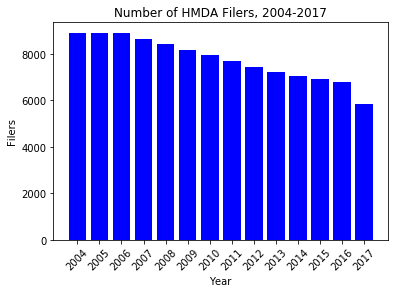

In [118]:
x = time_series()['Year'] #Uses the year column from the time_series data frame as x. 
y = time_series()['Filers'] #Uses the count of filers from the time_series data frame as y.
fig = plt.figure() 
plt.bar(x, y, color = 'blue') #Creates a bar chart using x and y, setting the color as blue. 
plt.title("Number of HMDA Filers, 2004-2017") #Set title of the chart. 
plt.ylabel("Filers") #Set y-axis label. 
plt.xlabel("Year") #Set x-axis label
plt.yticks=([])
plt.xticks(x, x, rotation='45') #Setting x-tick labels to 45 degrees. 
fig.savefig('analysis_output/charts/filer_count_time_series.png') #Saving output to a png file. 